In [ ]:
# imports

import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from plotnine import ggplot, aes, geom_point, theme_minimal, labs, geom_histogram, geom_density
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotnine import *
import numpy as np

# performance
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve

# pipeline imports from sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

**Question 1: What variables are the most influential for predicting the weight change over a specified duration?**

Linear Regression Model

In [ ]:
# load the data
d = pd.read_csv("weight_change_dataset.csv")
d.head()

,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs)
0,1,56,M,228.4,3102.3,3916.0,813.7,0.2,1,Sedentary,Excellent,6,228.6
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.4,6,Very Active,Excellent,6,167.8
2,3,32,F,142.8,2119.4,2785.4,666.0,1.4,7,Sedentary,Good,3,144.2
3,4,25,F,145.5,2181.3,2587.3,406.0,0.8,8,Sedentary,Fair,2,146.3
4,5,38,M,155.5,2463.8,3312.8,849.0,2.0,10,Lightly Active,Good,1,157.5


In [ ]:
predictors = ["Daily Caloric Surplus/Deficit", "Physical Activity Level", "Age", "BMR (Calories)", "Current Weight (lbs)"]

# drop missing
d.dropna(inplace = True)
d.reset_index(inplace = True, drop = True)

# split into X and y
X = d[predictors]
y = d["Weight Change (lbs)"]

# "Physical Activity Level" categorical to numeric using sklearn LabelEncoder
if X['Physical Activity Level'].dtype == 'object':
    le = LabelEncoder()
    X['Physical Activity Level'] = le.fit_transform(X['Physical Activity Level'])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

# z score
scaler = StandardScaler()

# I asked chatgbt how to write code for scaling only numerical variables
numerical_cols = ["Daily Caloric Surplus/Deficit", "Age", "BMR (Calories)", "Current Weight (lbs)"]
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# linear regression
lr = LinearRegression()

# validation
kf = LeaveOneOut()

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}


for train, test in kf.split(X_scaled):
    X_train = X_scaled.iloc[train]
    X_test = X_scaled.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

    # fit
    lr.fit(X_train,y_train)

    # predict
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))

print("Train MSEs:", mse["train"])
print("Test MSEs :", mse["test"])
print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))
print()

# coefficients of each feature
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_})
print(coefficients)


Train MSEs: [54.425570035445446, 54.39721051812859, 54.439141482948024, 54.45358930236094, 54.28630399863922, 53.15703138504958, 54.559306520385064, 43.94648364622585, 54.142404041780104, 54.4773208346132, 54.51362181569666, 54.39673823315428, 54.50101639282785, 54.55660006003161, 54.56085968056284, 54.426114061669, 54.31526319483048, 54.51810431492548, 54.403139666562446, 54.3275454678275, 54.21968103268595, 54.42373568959439, 54.53499515278888, 54.195575247713634, 50.64195409205638, 54.47438829952042, 54.07299701714052, 54.50331630513439, 54.379946446160545, 54.02874746564934, 54.00500773420989, 54.55520773800366, 54.55933280969382, 54.21386540381434, 54.34215876496061, 54.494237707714746, 54.126927183308474, 46.056990730991316, 54.23087262829122, 54.14293809918737, 54.28417825140022, 54.54875358630922, 54.25352546068754, 54.561132507280306, 54.527965200969106, 53.9532402562471, 54.47658679631085, 53.941256092177355, 54.516444182713464, 54.2792614772016, 52.080947409088125, 54.543774

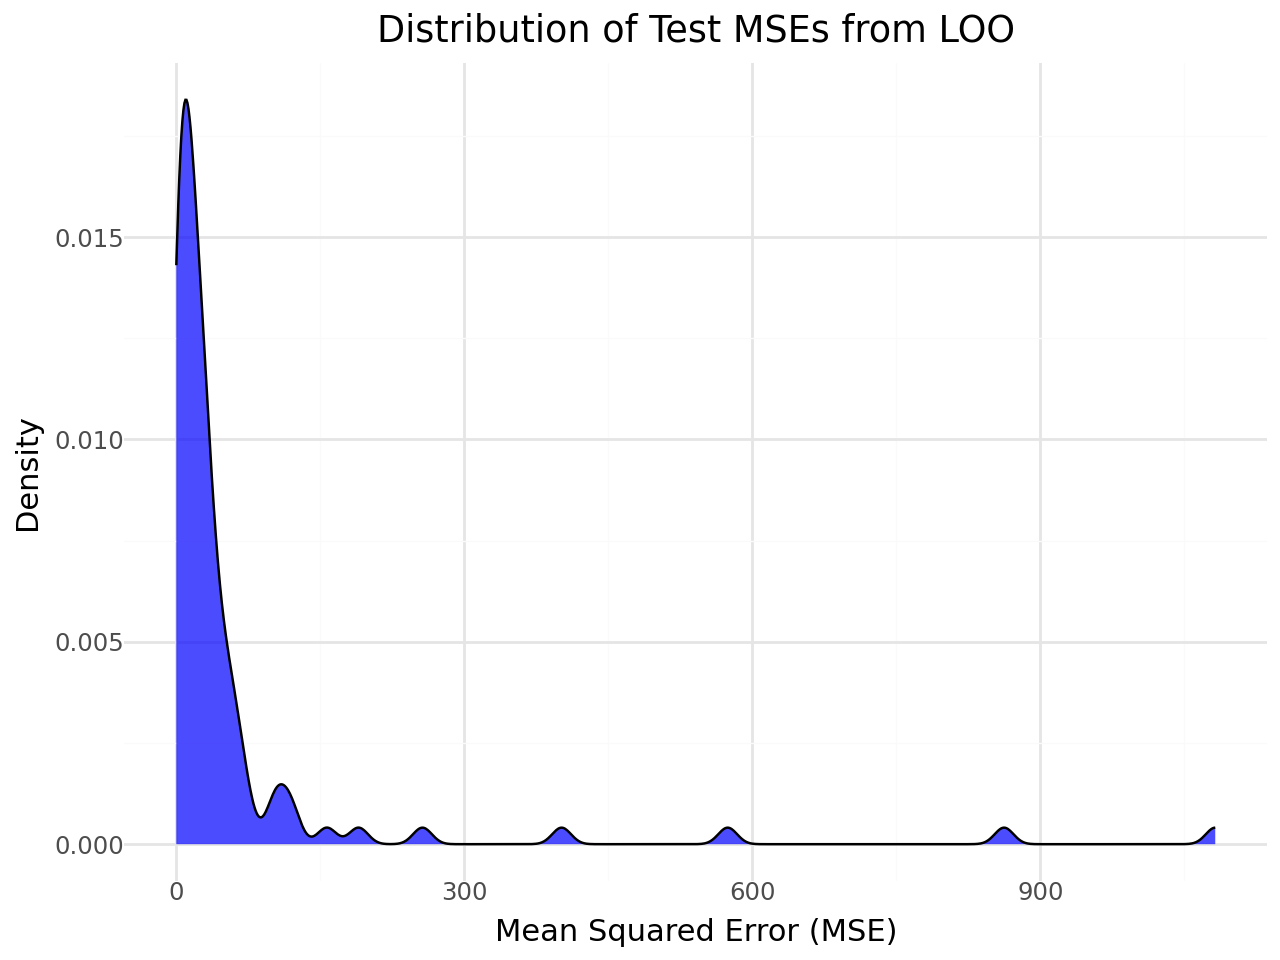

In [ ]:
results_d = pd.DataFrame({'Test_MSE': mse["test"]})

(ggplot(results_d, aes(x="Test_MSE")) +
    geom_density(fill="blue", color="black", alpha=0.7) +
    labs(title="Distribution of Test MSEs from LOO", x="Mean Squared Error (MSE)", y="Density") +
    theme_minimal())

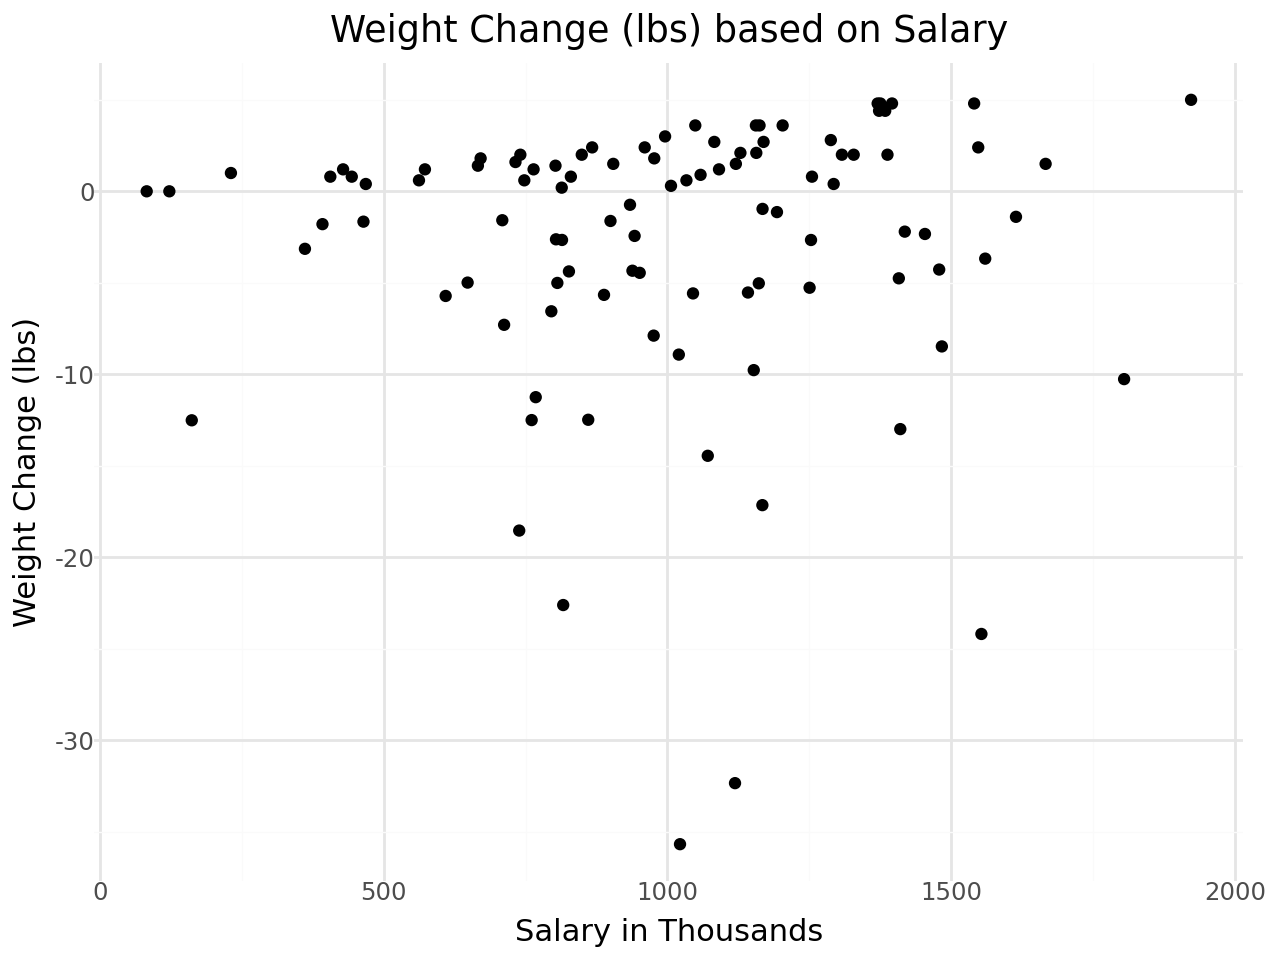

In [ ]:
(ggplot(d,aes(x = "Daily Caloric Surplus/Deficit", y = "Weight Change (lbs)"))+ geom_point(color = "black", alpha=1)
                    + theme_minimal()) + labs(x="Salary in Thousands", y="Weight Change (lbs)",title="Weight Change (lbs) based on Salary")

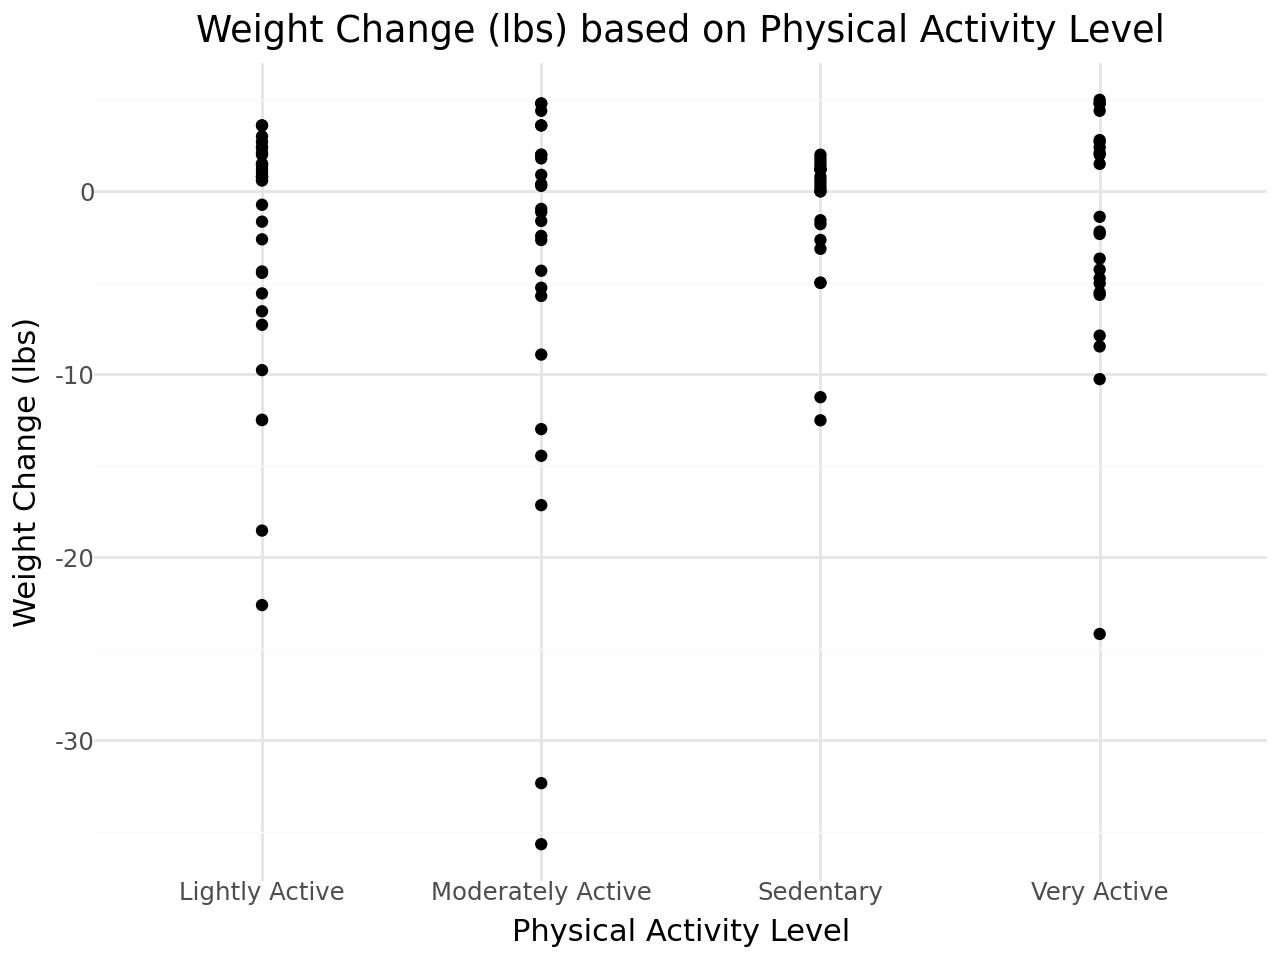

In [ ]:
(ggplot(d,aes(x = "Physical Activity Level", y = "Weight Change (lbs)"))+ geom_point(color = "black", alpha=1)
                    + theme_minimal()) + labs(x="Physical Activity Level", y="Weight Change (lbs)",title="Weight Change (lbs) based on Physical Activity Level")

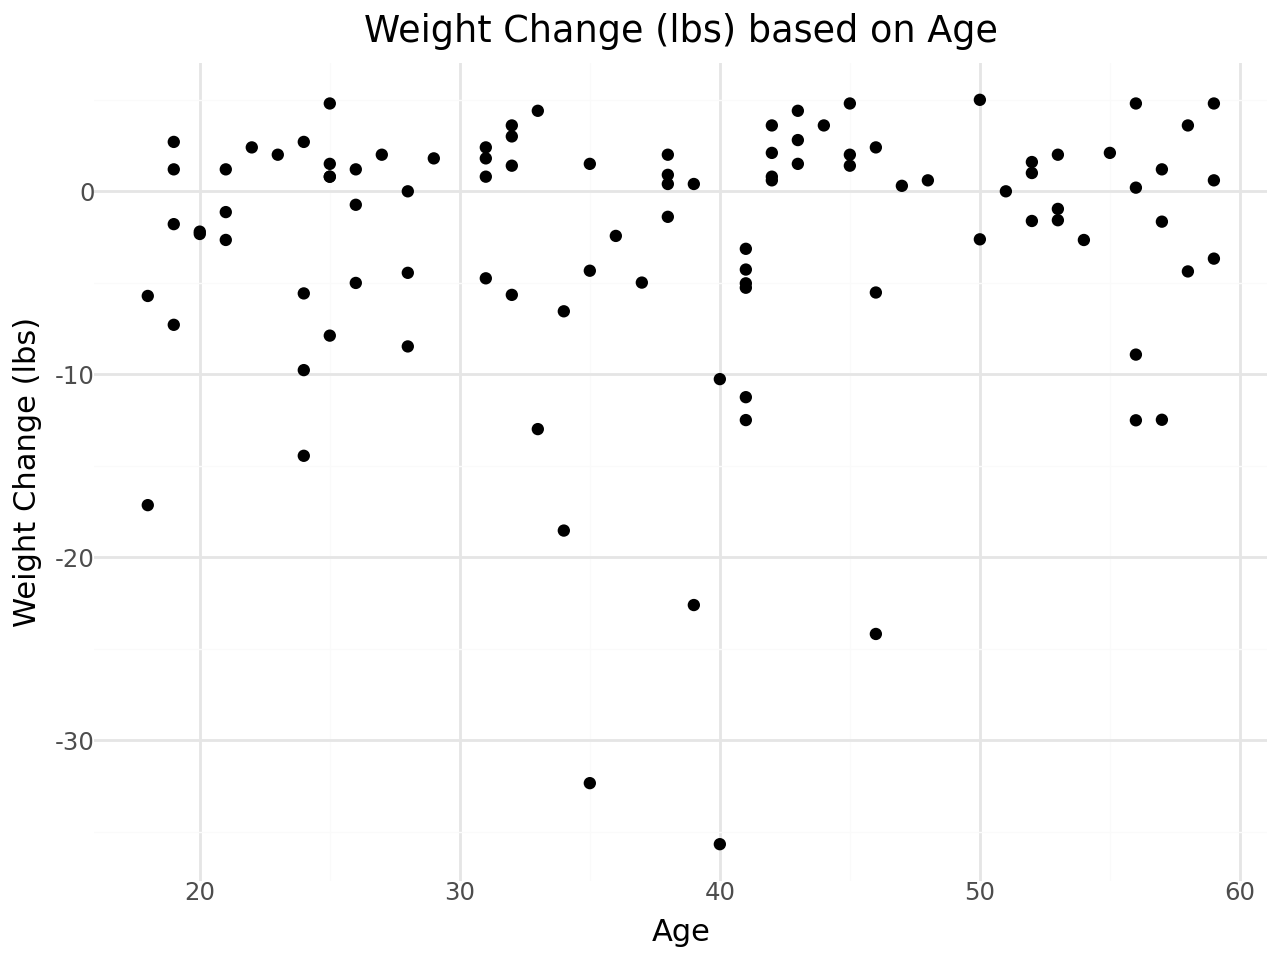

In [ ]:
(ggplot(d,aes(x = "Age", y = "Weight Change (lbs)"))+ geom_point(color = "black", alpha=1)
                    + theme_minimal()) + labs(x="Age", y="Weight Change (lbs)",title="Weight Change (lbs) based on Age")

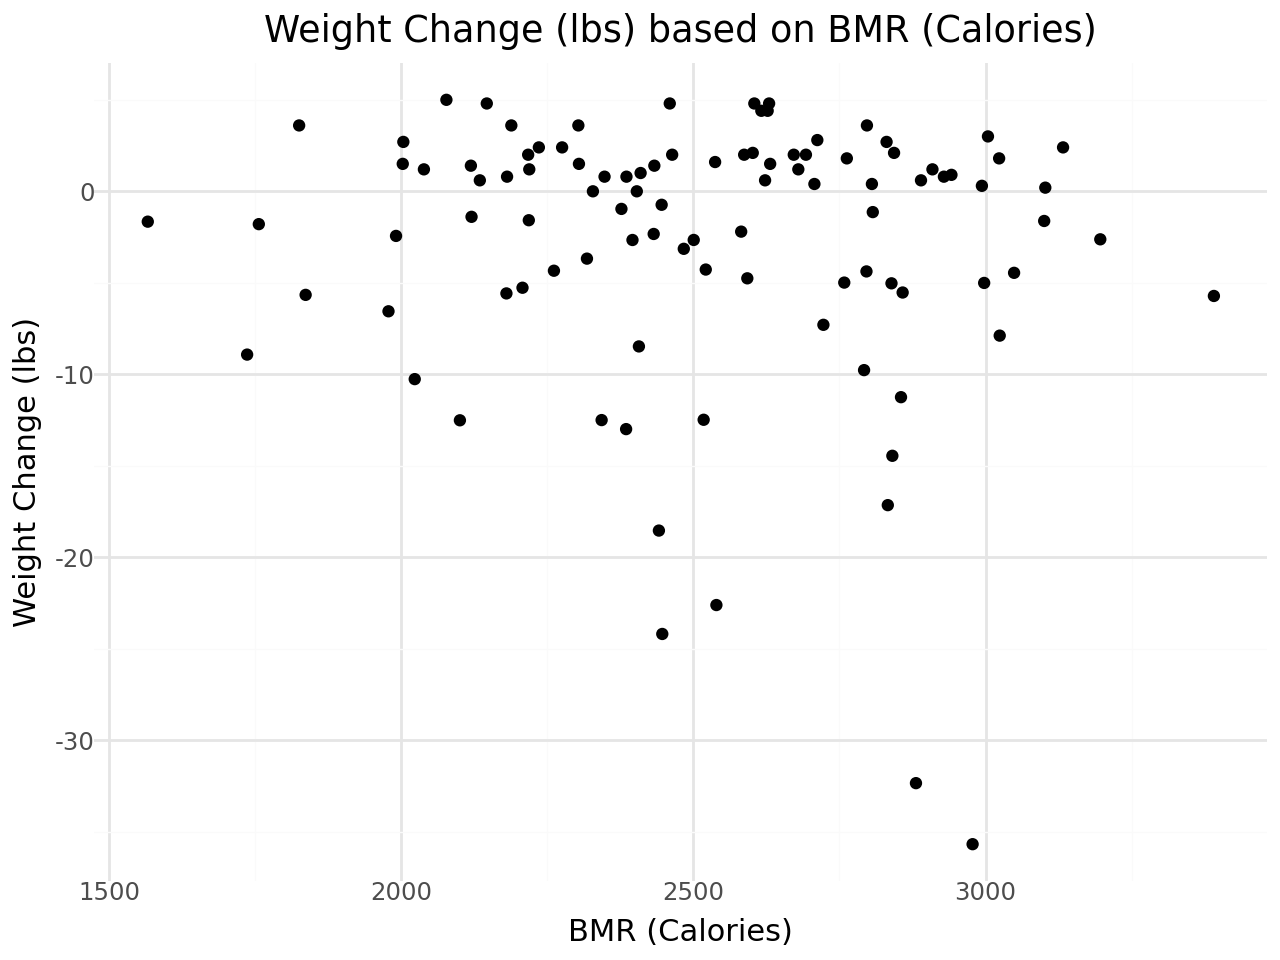

In [ ]:
(ggplot(d,aes(x = "BMR (Calories)", y = "Weight Change (lbs)"))+ geom_point(color = "black", alpha=1)
                    + theme_minimal()) + labs(x="BMR (Calories)", y="Weight Change (lbs)",title="Weight Change (lbs) based on BMR (Calories)")

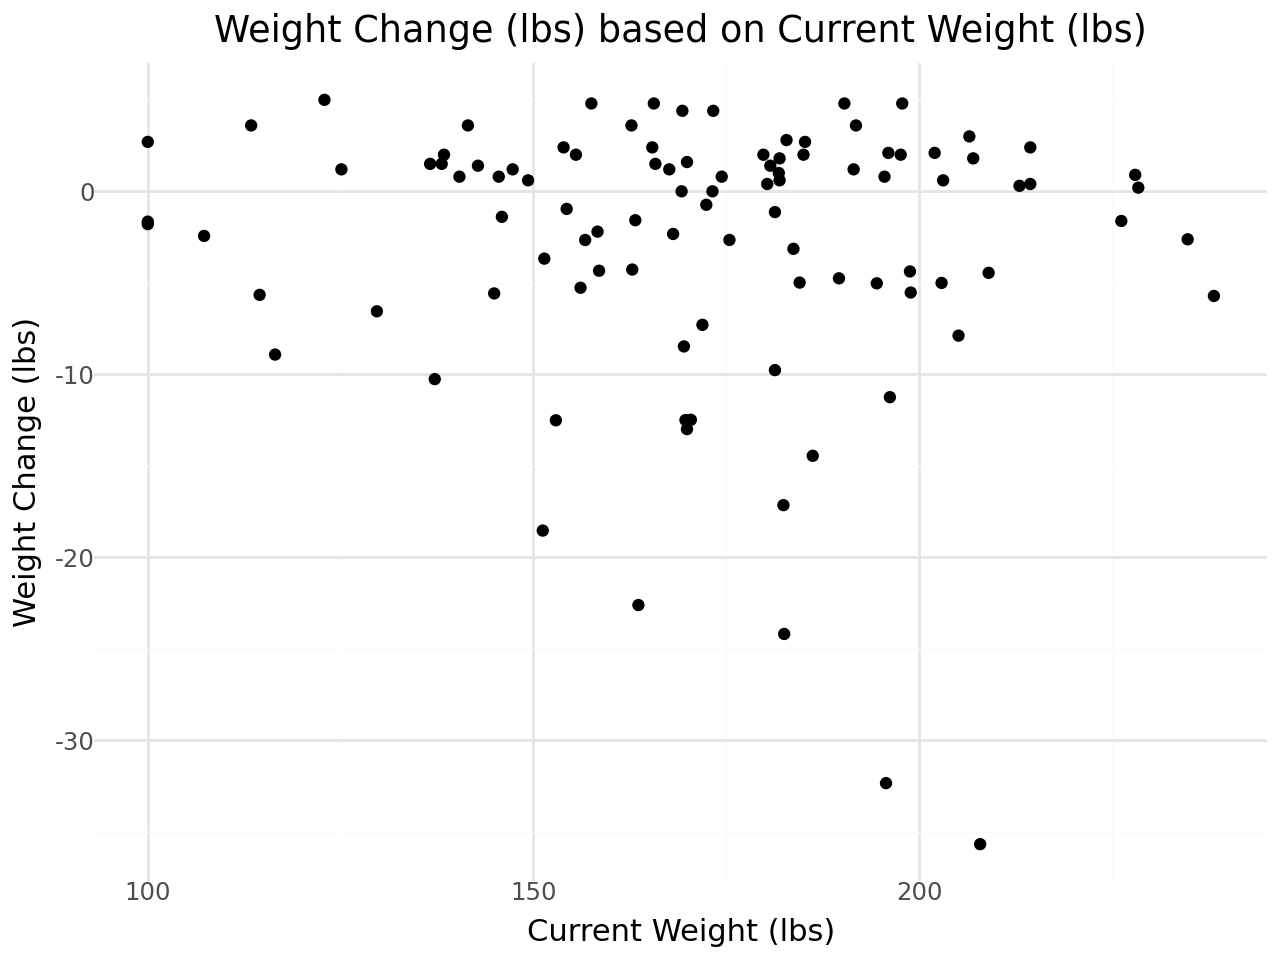

In [ ]:
(ggplot(d,aes(x = "Current Weight (lbs)", y = "Weight Change (lbs)"))+ geom_point(color = "black", alpha=1)
                    + theme_minimal()) + labs(x="Current Weight (lbs)", y="Weight Change (lbs)",title="Weight Change (lbs) based on Current Weight (lbs)")

**Question 2: (Clustering) When clustering participants by age, BMR, caloric surplus/deficit, and physical activity level, what clusters emerge, and what are their characteristics?**

K-means

0.016704527838671168


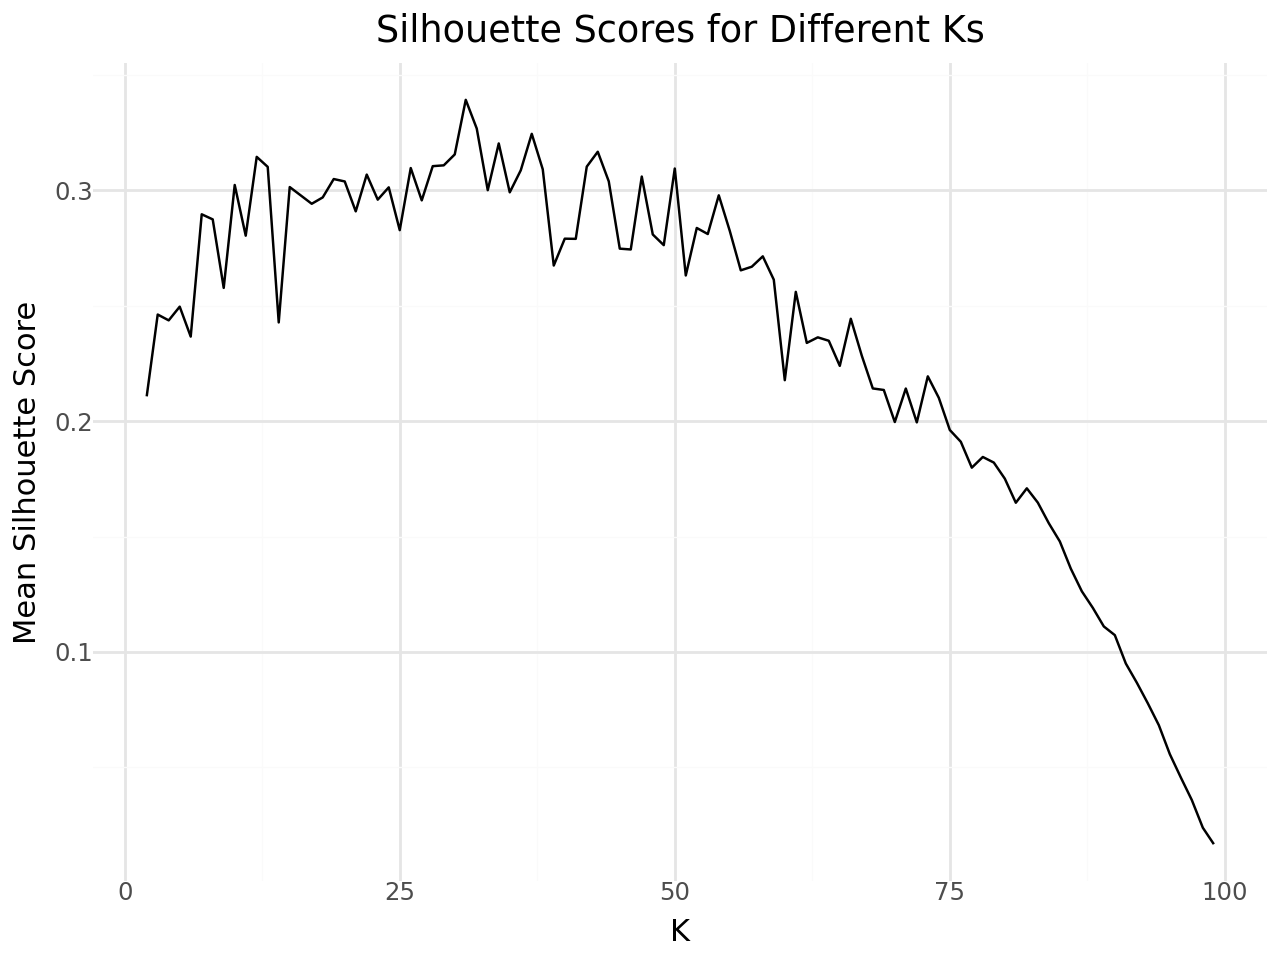

In [ ]:
# grab data we want to cluster
feats = ["Daily Caloric Surplus/Deficit", "Physical Activity Level", "Age", "BMR (Calories)"]

X = d[feats]

# "Physical Activity Level" categorical to numeric using sklearn LabelEncoder
if X['Physical Activity Level'].dtype == 'object':
    le = LabelEncoder()
    X['Physical Activity Level'] = le.fit_transform(X['Physical Activity Level'])

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# create dictionary to
metrics = {"sil": [], "k": []}

for i in range(2, min(101, X_scaled.shape[0])):
    km = KMeans(i)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)

    metrics["sil"].append(sil)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

# assess model
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

(ggplot(df, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))


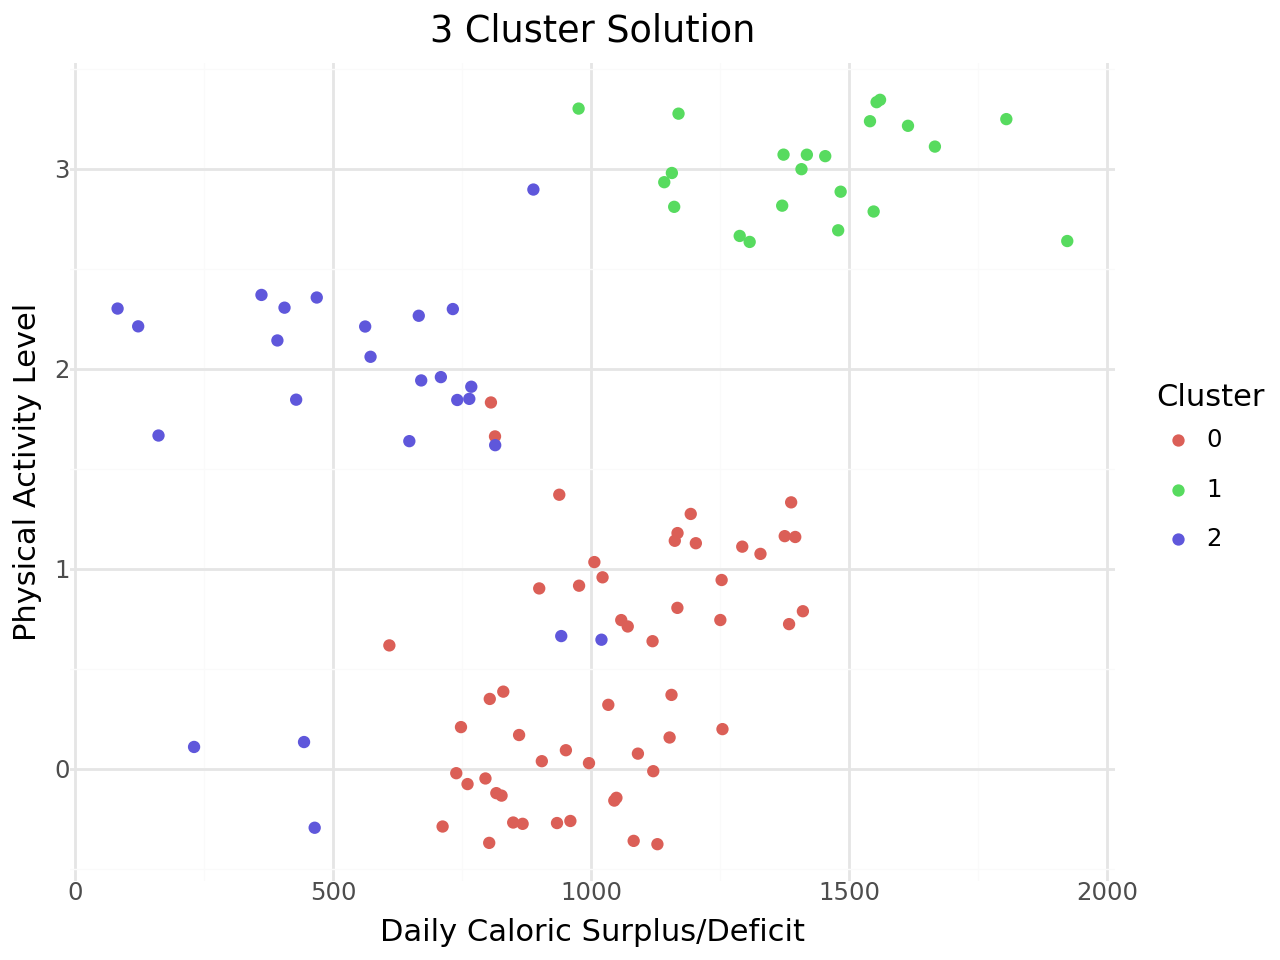

In [ ]:
#tested out different KMeans to see which one works best
#km = KMeans(37)
km = KMeans(3)
labels = km.fit_predict(X_scaled)

X["cluster"] = labels
(ggplot(X, aes(x = "Daily Caloric Surplus/Deficit", y = "Physical Activity Level", color = "factor(cluster)")) +
      geom_jitter() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Daily Caloric Surplus/Deficit",
           y = "Physical Activity Level",
           title = "3 Cluster Solution"))


In [ ]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

0.2577479344151932


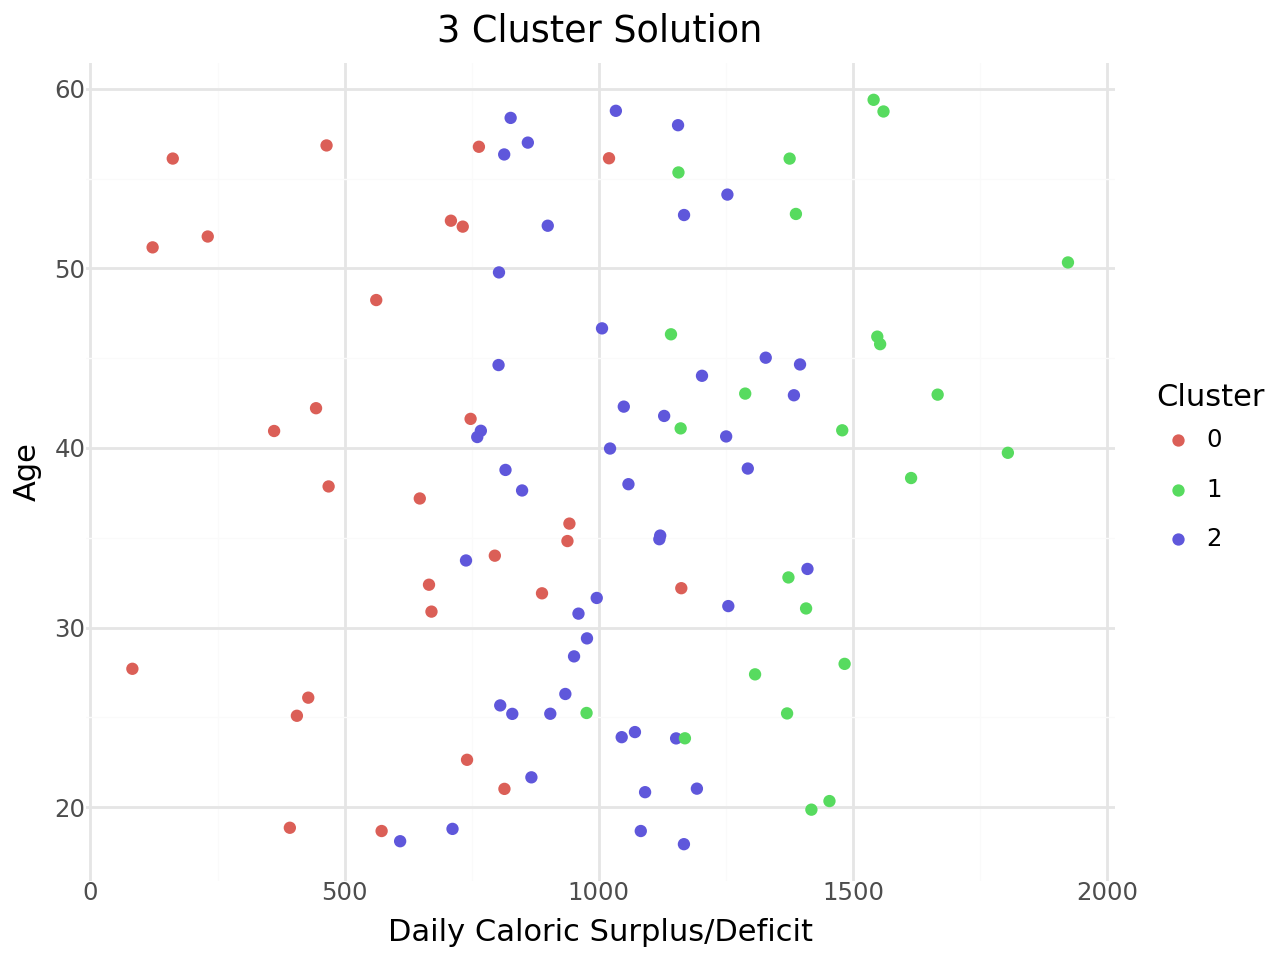

In [ ]:
km = KMeans(3) #tested out different KMeans to see which one works best
labels = km.fit_predict(X_scaled)

X["cluster"] = labels
(ggplot(X, aes(x = "Daily Caloric Surplus/Deficit", y = "Age", color = "factor(cluster)")) +
      geom_jitter() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Daily Caloric Surplus/Deficit",
           y = "Age",
           title = "3 Cluster Solution"))

In [ ]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

0.24390551697521098


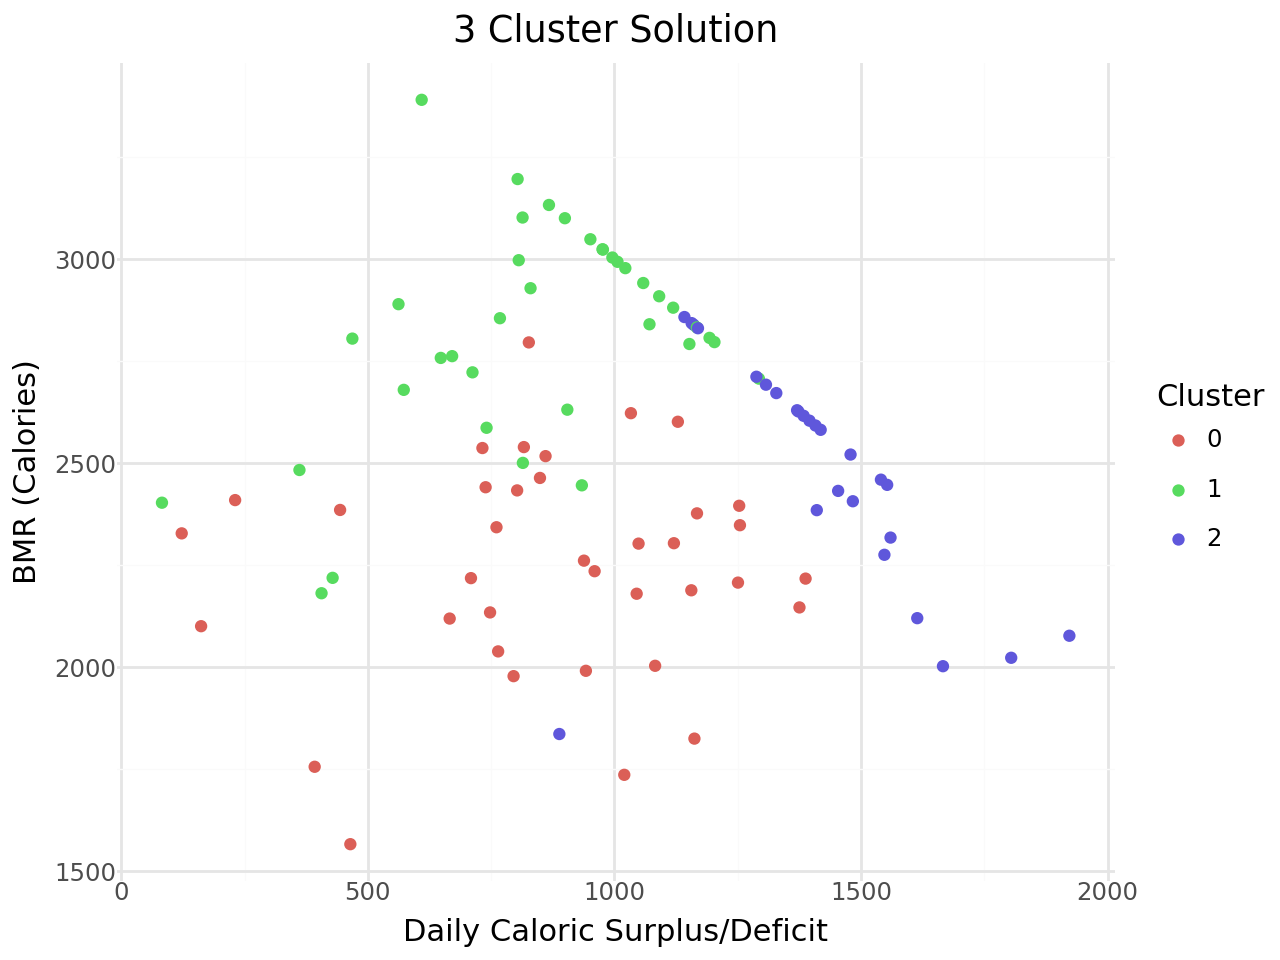

In [ ]:
km = KMeans(3) #tested out different KMeans to see which one works best
labels = km.fit_predict(X_scaled)

X["cluster"] = labels
(ggplot(X, aes(x = "Daily Caloric Surplus/Deficit", y = "BMR (Calories)", color = "factor(cluster)")) +
      geom_jitter() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Daily Caloric Surplus/Deficit",
           y = "BMR (Calories)",
           title = "3 Cluster Solution"))

In [ ]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

0.24565248222836616


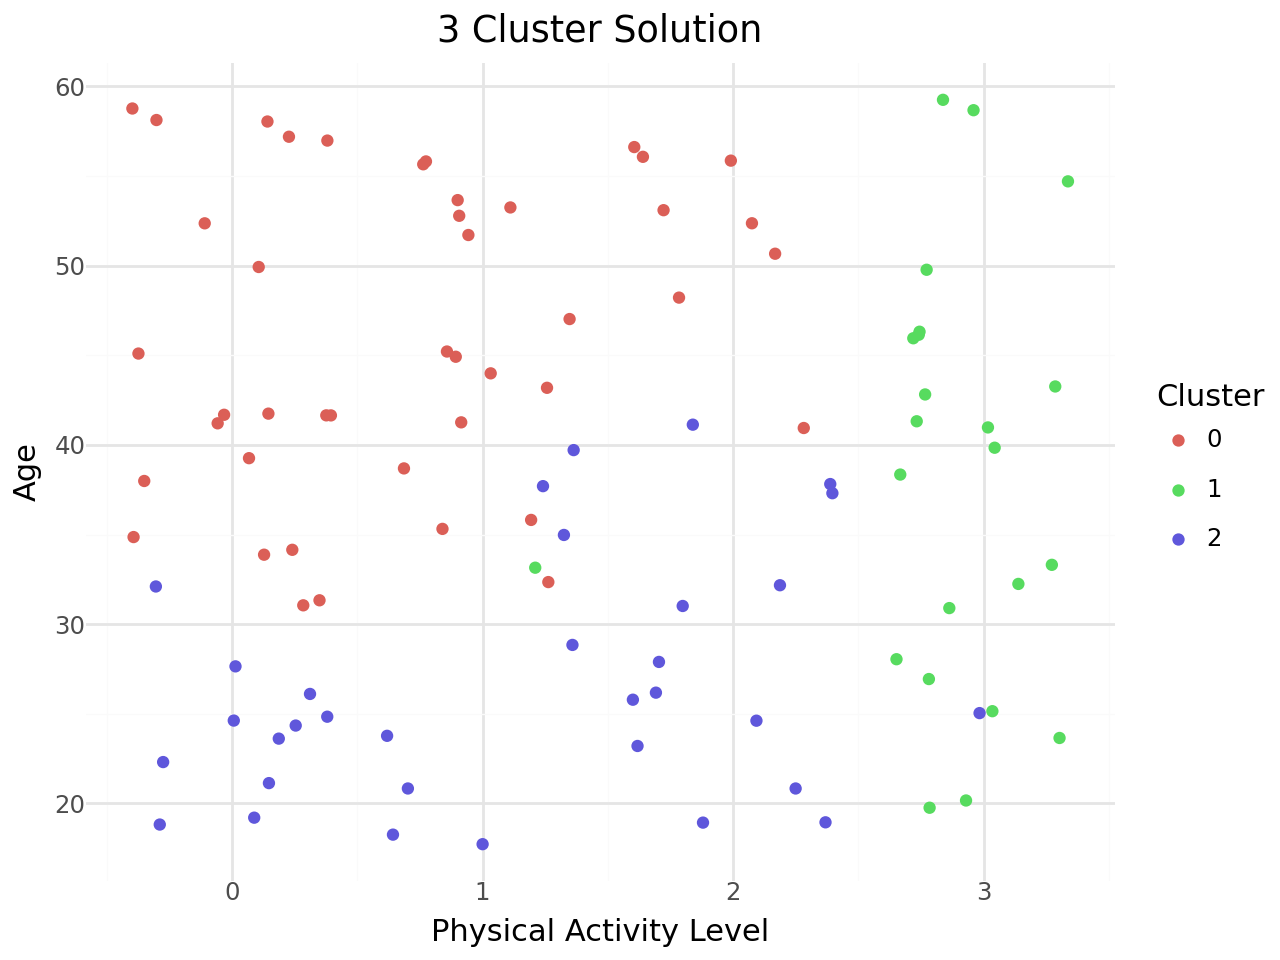

In [ ]:
km = KMeans(3) #tested out different KMeans to see which one works best
labels = km.fit_predict(X_scaled)

X["cluster"] = labels
(ggplot(X, aes(x = "Physical Activity Level", y = "Age", color = "factor(cluster)")) +
      geom_jitter() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Physical Activity Level",
           y = "Age",
           title = "3 Cluster Solution"))

In [ ]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

0.23696810209232333


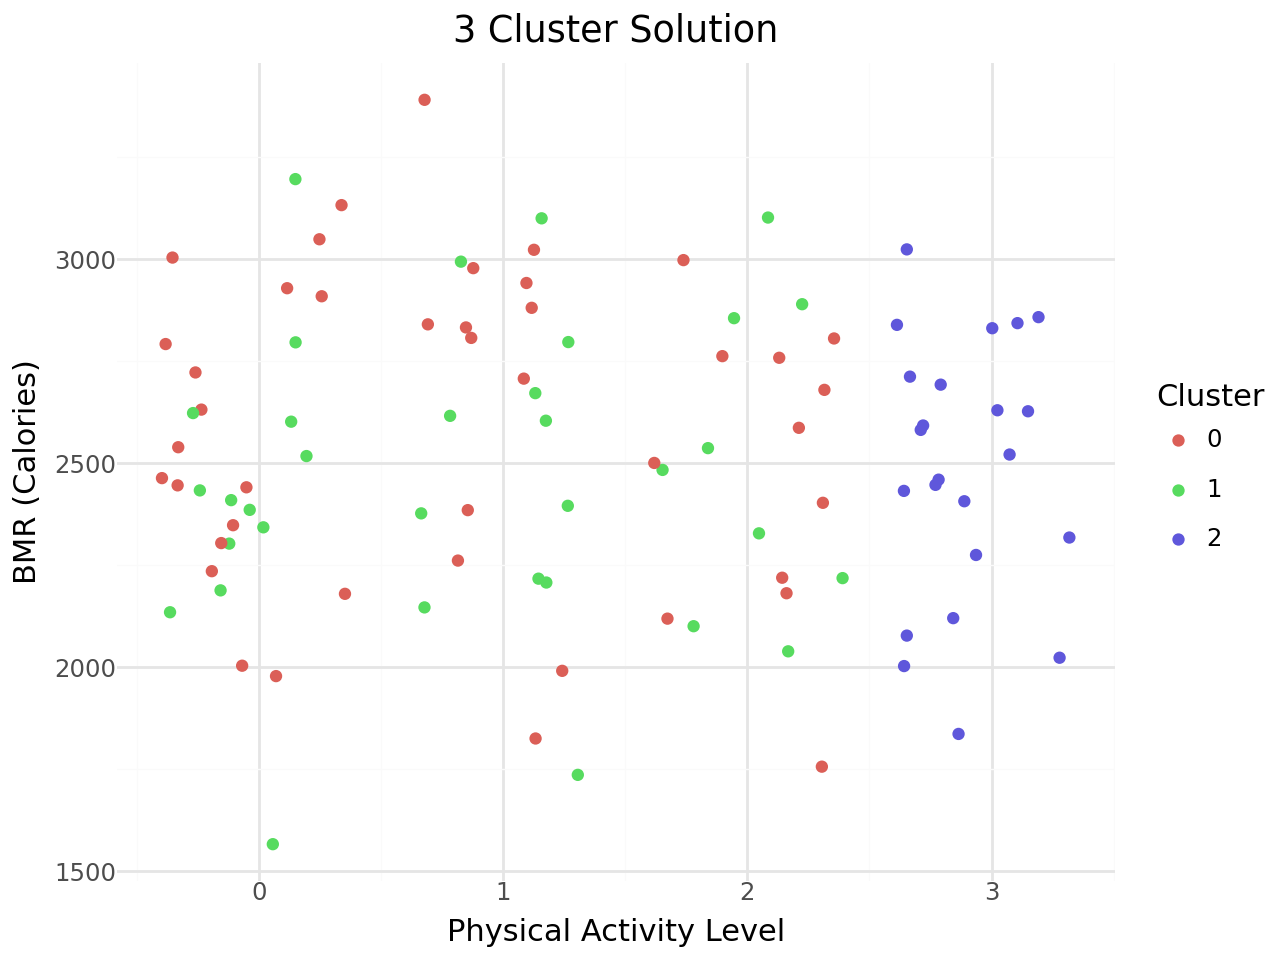

In [ ]:
km = KMeans(3) #tested out different KMeans to see which one works best
labels = km.fit_predict(X_scaled)

X["cluster"] = labels
(ggplot(X, aes(x = "Physical Activity Level", y = "BMR (Calories)", color = "factor(cluster)")) +
      geom_jitter() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Physical Activity Level",
           y = "BMR (Calories)",
           title = "3 Cluster Solution"))

In [ ]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

0.23036533295709877


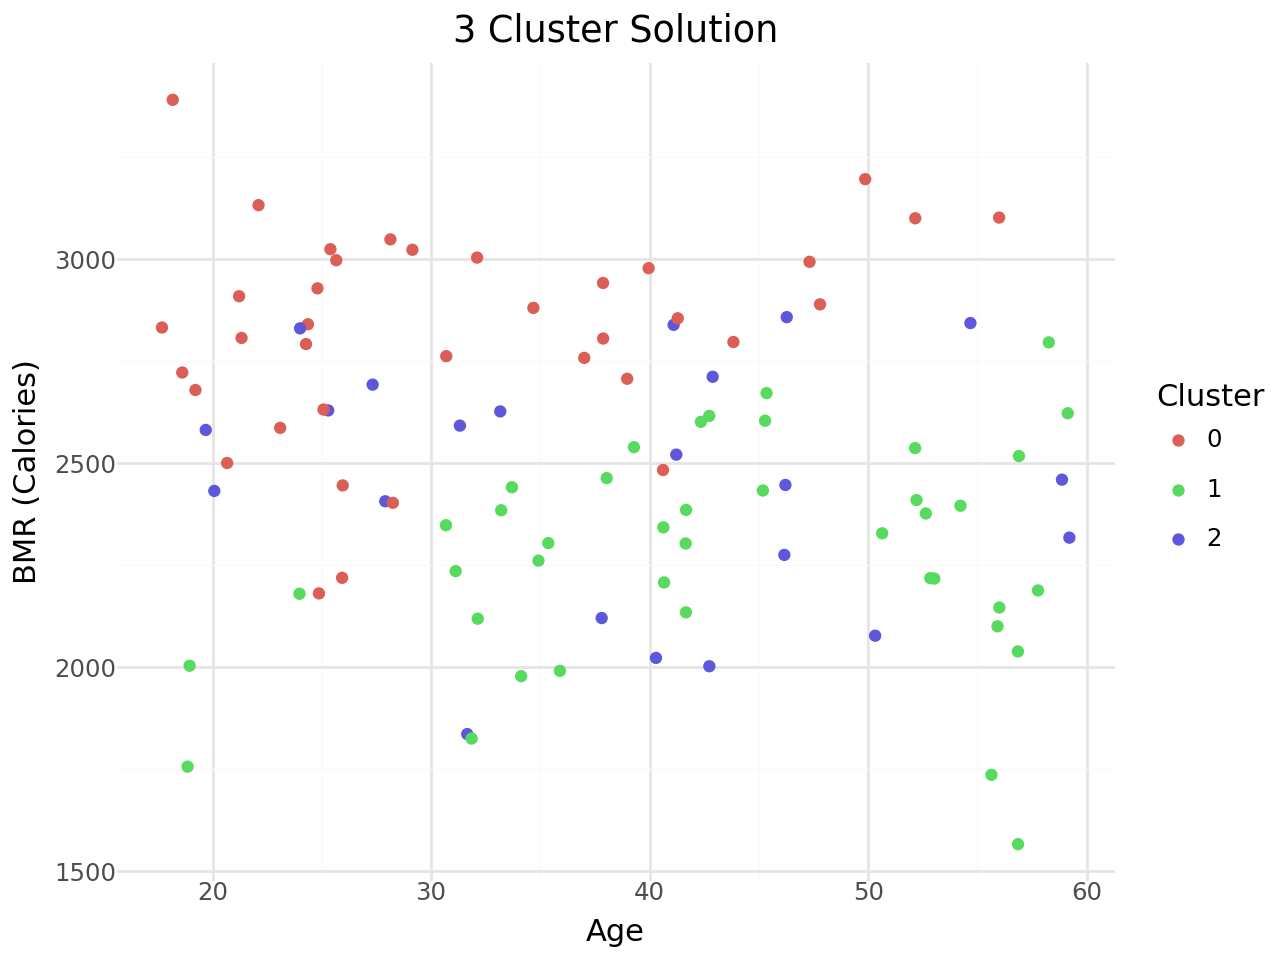

In [ ]:
km = KMeans(3) #tested out different KMeans to see which one works best
labels = km.fit_predict(X_scaled)

X["cluster"] = labels
(ggplot(X, aes(x = "Age", y = "BMR (Calories)", color = "factor(cluster)")) +
      geom_jitter() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Age",
           y = "BMR (Calories)",
           title = "3 Cluster Solution"))


In [ ]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(silhouette_avg)

0.2520917735399147


**Question 3: (Supervised Model): How do sleep quality and stress level together impact the consistency of physical activity levels over time, and can we identify a pattern or trend across age groups?**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures #Z-score variables, Polynomial
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, accuracy_score #model evaluation
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

data = pd.read_csv("/content/weight_change_dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Participant ID                 100 non-null    int64  
 1   Age                            100 non-null    int64  
 2   Gender                         100 non-null    object 
 3   Current Weight (lbs)           100 non-null    float64
 4   BMR (Calories)                 100 non-null    float64
 5   Daily Calories Consumed        100 non-null    float64
 6   Daily Caloric Surplus/Deficit  100 non-null    float64
 7   Weight Change (lbs)            100 non-null    float64
 8   Duration (weeks)               100 non-null    int64  
 9   Physical Activity Level        100 non-null    object 
 10  Sleep Quality                  100 non-null    object 
 11  Stress Level                   100 non-null    int64  
 12  Final Weight (lbs)             100 non-null    floa

Train MSE :  3.9776163286126476
Train MAE :  1.7053998710270981
Train MAPE:  0.7026716571203618
Train R2  :  0.37599900717911205
Test MSE  :  4.833966000835138
Test MAE  :  1.9298532232692787
Test MAPE :  0.6137611239407665
Test R2  :  0.3311703907526615


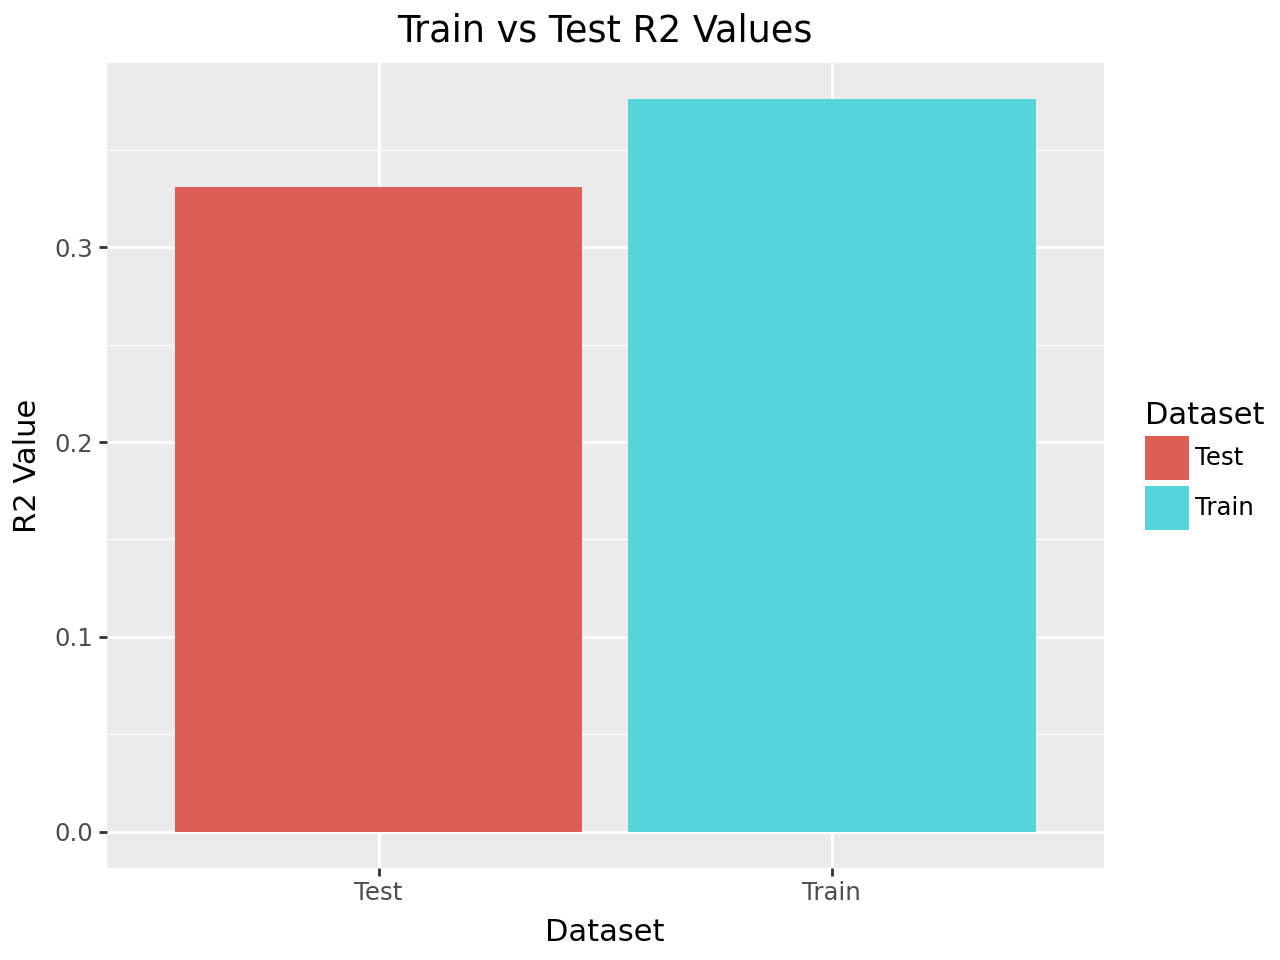

In [ ]:
predictors = ["Age", "Gender", "Current Weight (lbs)", "BMR (Calories)", "Daily Calories Consumed", "Daily Caloric Surplus/Deficit",
              "Weight Change (lbs)", "Duration (weeks)", "Physical Activity Level", "Sleep Quality", "Final Weight (lbs)"]

contin = ["Age", "Current Weight (lbs)", "BMR (Calories)", "Daily Calories Consumed", "Daily Caloric Surplus/Deficit",
              "Weight Change (lbs)", "Duration (weeks)", "Final Weight (lbs)"]

X = data[predictors]
y = data["Stress Level"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1234)

z = make_column_transformer((StandardScaler(), contin),
                            (OneHotEncoder(), ["Gender", "Physical Activity Level", "Sleep Quality"]),
                            remainder = "passthrough")


lr = LinearRegression()



pipe = Pipeline([
    ("zscore", z),
#    ("poly", PolynomialFeatures(degree = 2)),                       # this is for the polynomial regression, comment out for just linear regression
    ("linearregression", lr)
])

pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)
# assess - probably don't need MSE, MAE, etc.
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2  : ", r2_score(y_test,y_pred_test))

data2 = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'R2 Value': [r2_score(y_train,y_pred_train), r2_score(y_test,y_pred_test)]
})

# Plot

ggplot(data2, aes(x="Dataset", y="R2 Value", fill="Dataset")) + geom_bar(stat='identity', position='dodge') + labs(title='Train vs Test R2 Values', x='Dataset', y='R2 Value')

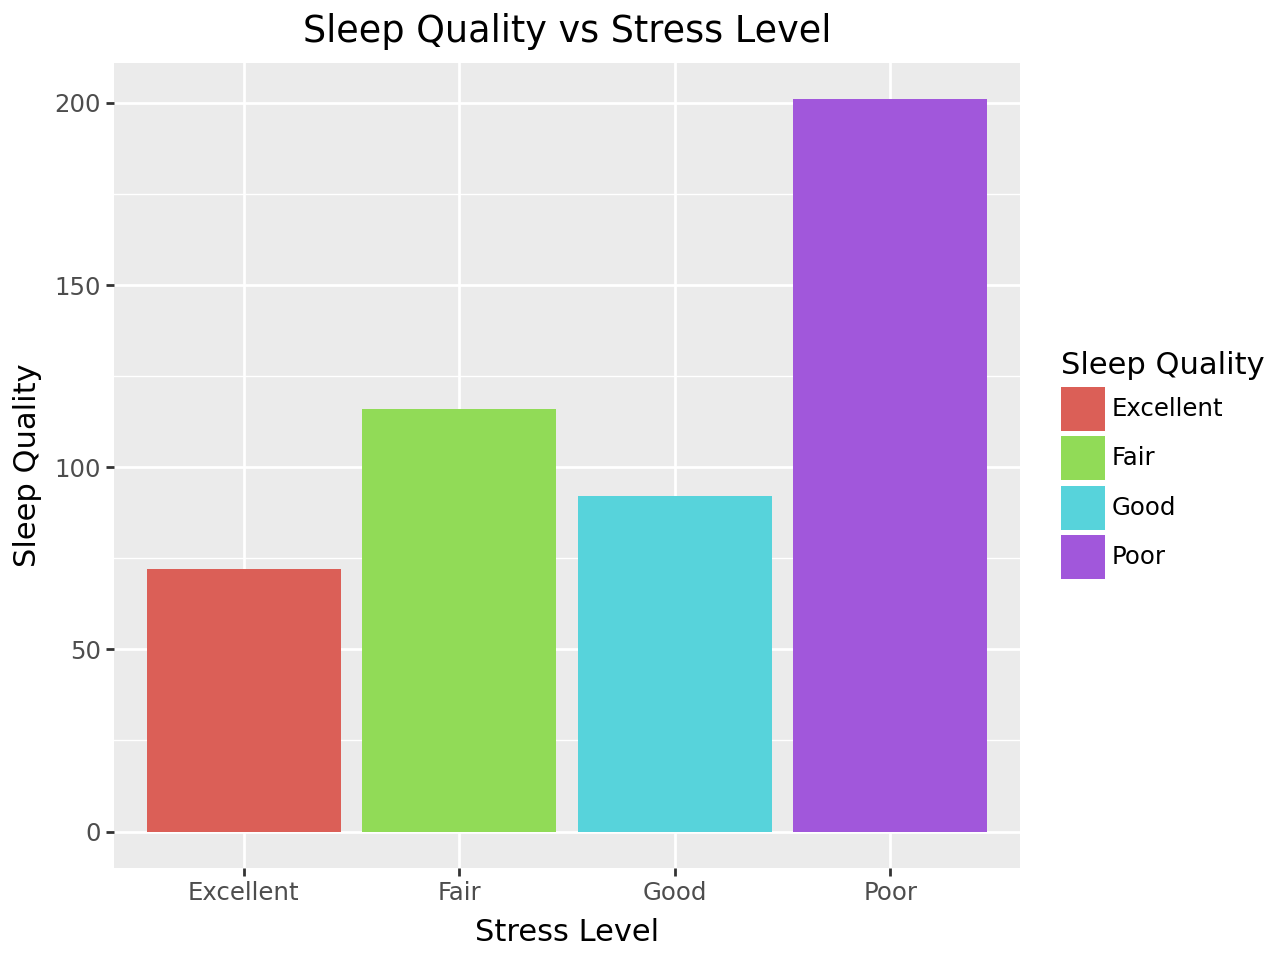

In [ ]:

 (ggplot(data, aes(x="Sleep Quality", y ="Stress Level", fill="Sleep Quality")) +
      geom_bar(stat="identity") +
      labs(title="Sleep Quality vs Stress Level", x = "Stress Level", y = "Sleep Quality"))

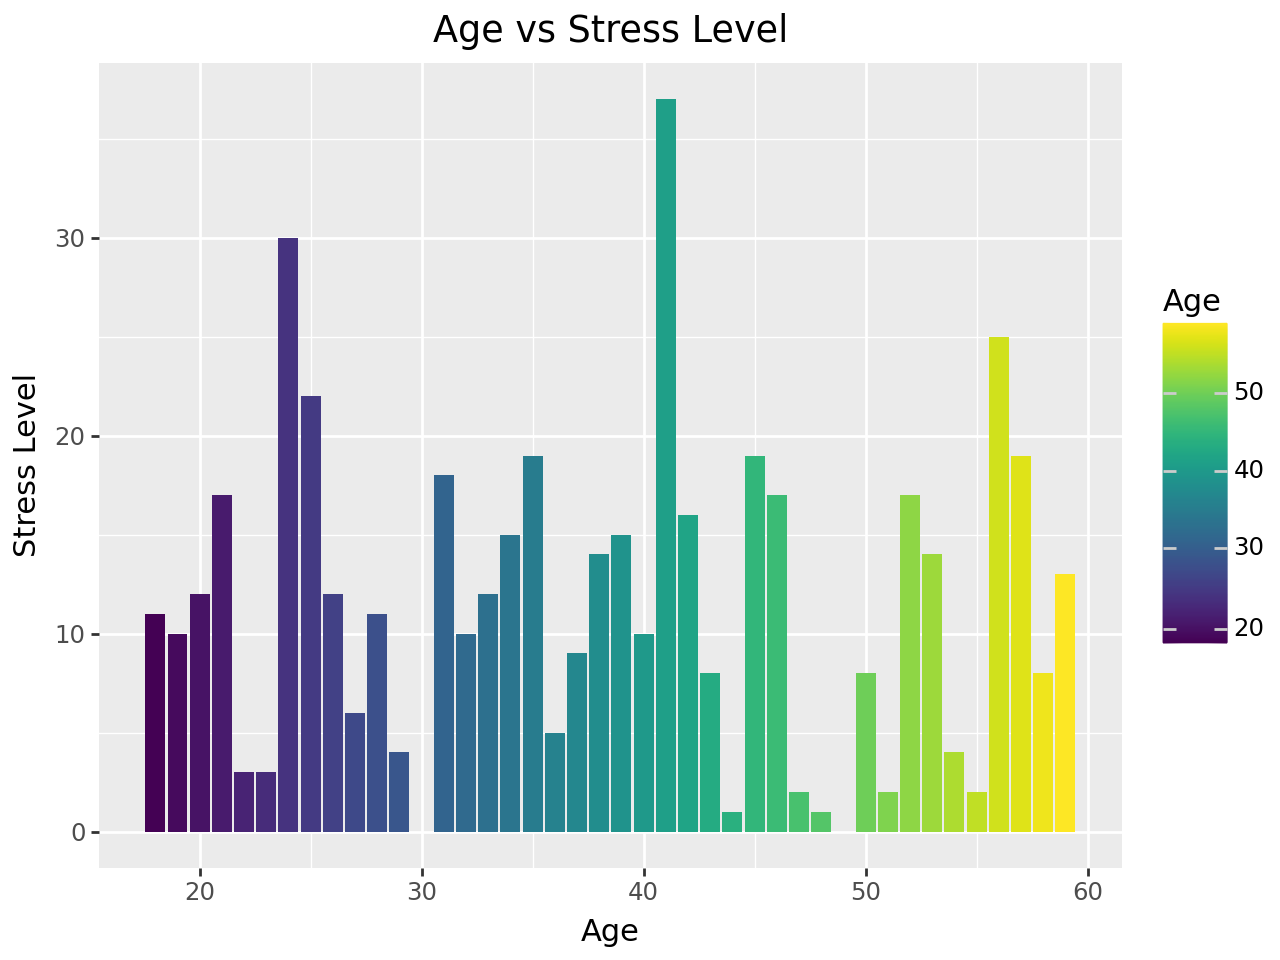

In [ ]:
ggplot(data, aes(x="Age", y = "Stress Level", fill="Age")) + geom_bar(stat="identity") + labs(title="Age vs Stress Level", x = "Age", y = "Stress Level")

**Question 4: Question: (Dimensionality Reduction) How does a model using PCA on all continuous variables (BMR, daily caloric surplus/deficit, stress level) compare to a model with the original variables in terms of mean squared error when predicting final weight?**

In [ ]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from plotnine import ggplot, aes, geom_line, geom_point, geom_hline, theme_minimal, labs

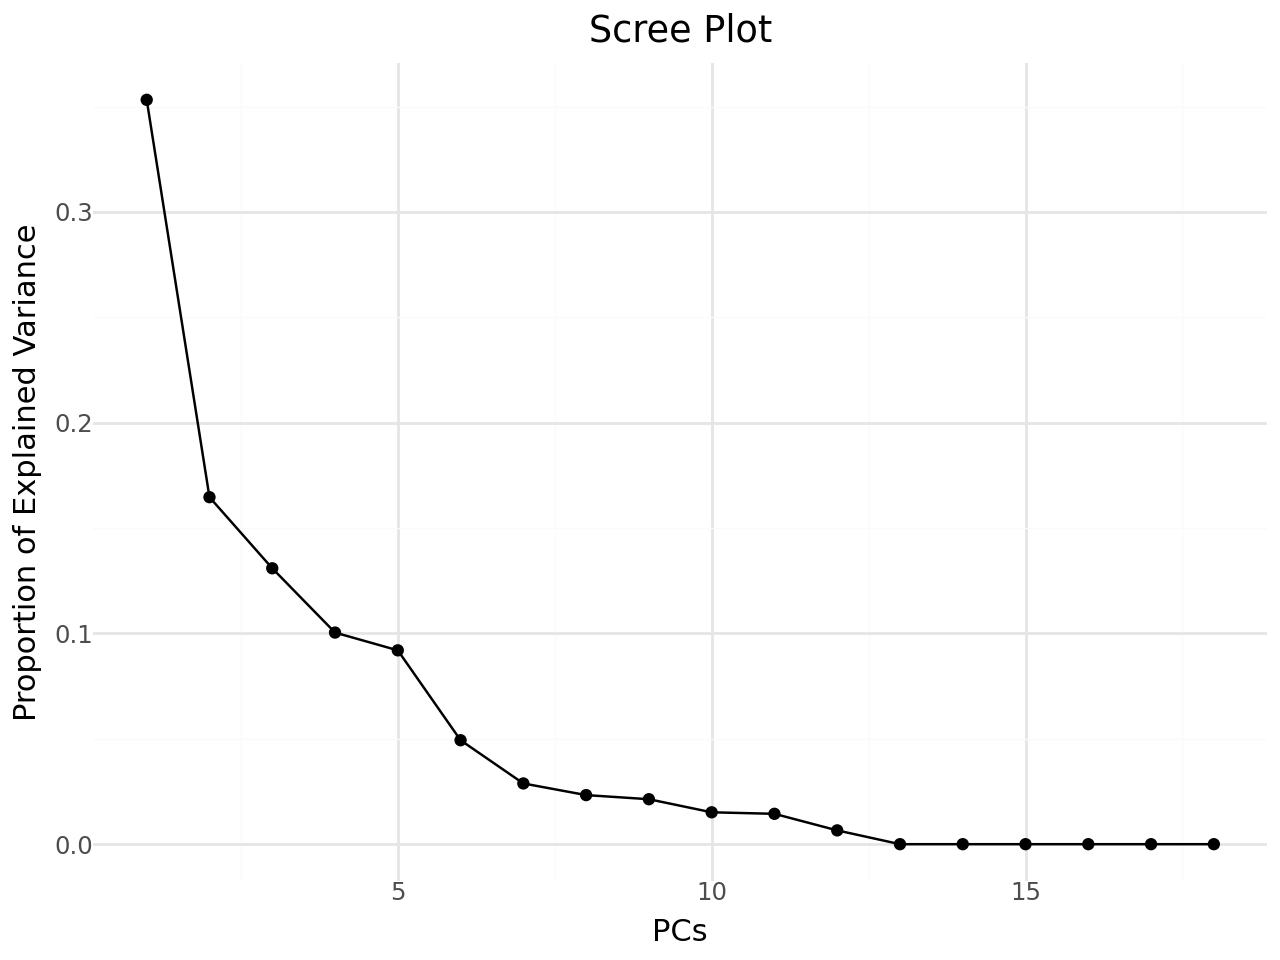

In [ ]:
predictors = ["Age", "Gender", "Current Weight (lbs)", "BMR (Calories)",
              "Daily Calories Consumed", "Daily Caloric Surplus/Deficit",
              "Weight Change (lbs)", "Duration (weeks)",
              "Physical Activity Level", "Sleep Quality", "Final Weight (lbs)"]

contin = ["Age", "Current Weight (lbs)", "BMR (Calories)", "Daily Calories Consumed",
          "Daily Caloric Surplus/Deficit", "Weight Change (lbs)",
          "Duration (weeks)", "Final Weight (lbs)"]

data_sub = data[predictors]

z = make_column_transformer(
    (StandardScaler(), contin),
    (OneHotEncoder(), ["Gender", "Physical Activity Level", "Sleep Quality"]),
    remainder="passthrough"
)

# PCA pipeline
pca = PCA()
pipe = Pipeline([
    ("z", z),
    ("pca", pca)
])

pipe.fit(data_sub)

# Dynamically determine the number of components
num_components = len(pipe.named_steps["pca"].explained_variance_ratio_)

# Create the df for explained variance
pcaDF = pd.DataFrame({
    "expl_var": pipe.named_steps["pca"].explained_variance_ratio_,
    "pc": range(1, num_components + 1),
    "cum_var": pipe.named_steps["pca"].explained_variance_ratio_.cumsum()
})

# Scree plot
ggplot(pcaDF, aes(x="pc", y="expl_var")) + geom_line() + geom_point() + theme_minimal() + labs(x="PCs", y="Proportion of Explained Variance", title="Scree Plot")

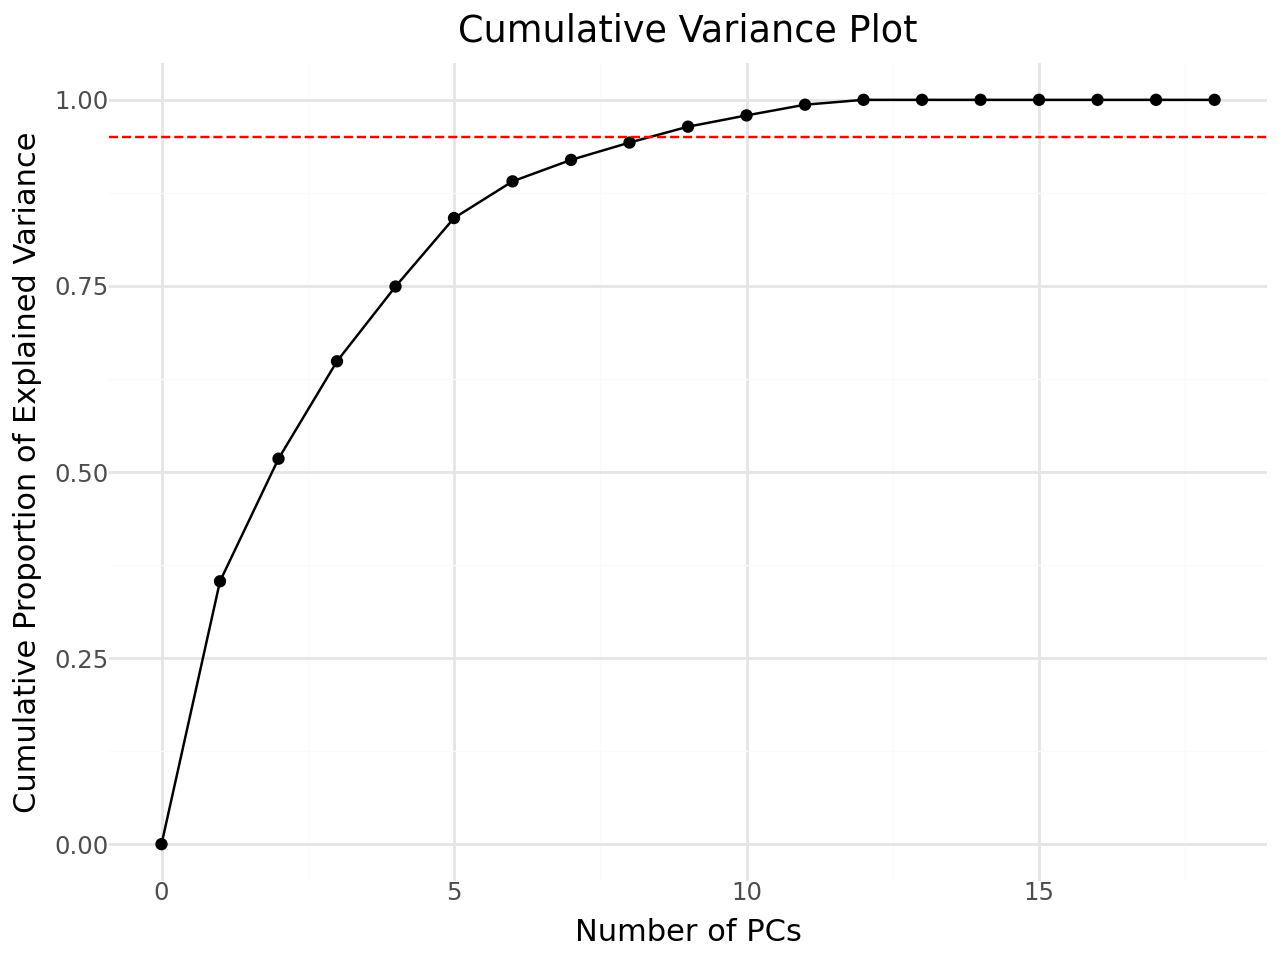

In [ ]:
# cum var plot
pcaDF0 = pd.concat([pcaDF, pd.DataFrame({"pc": [0], "cum_var": [0]})])  # Add (0,0) for reference

ggplot(pcaDF0, aes(x="pc", y="cum_var")) + geom_line() + geom_point() + geom_hline(yintercept=0.95, color="red", linetype="dashed") + theme_minimal() + labs(x="Number of PCs", y="Cumulative Proportion of Explained Variance", title="Cumulative Variance Plot")


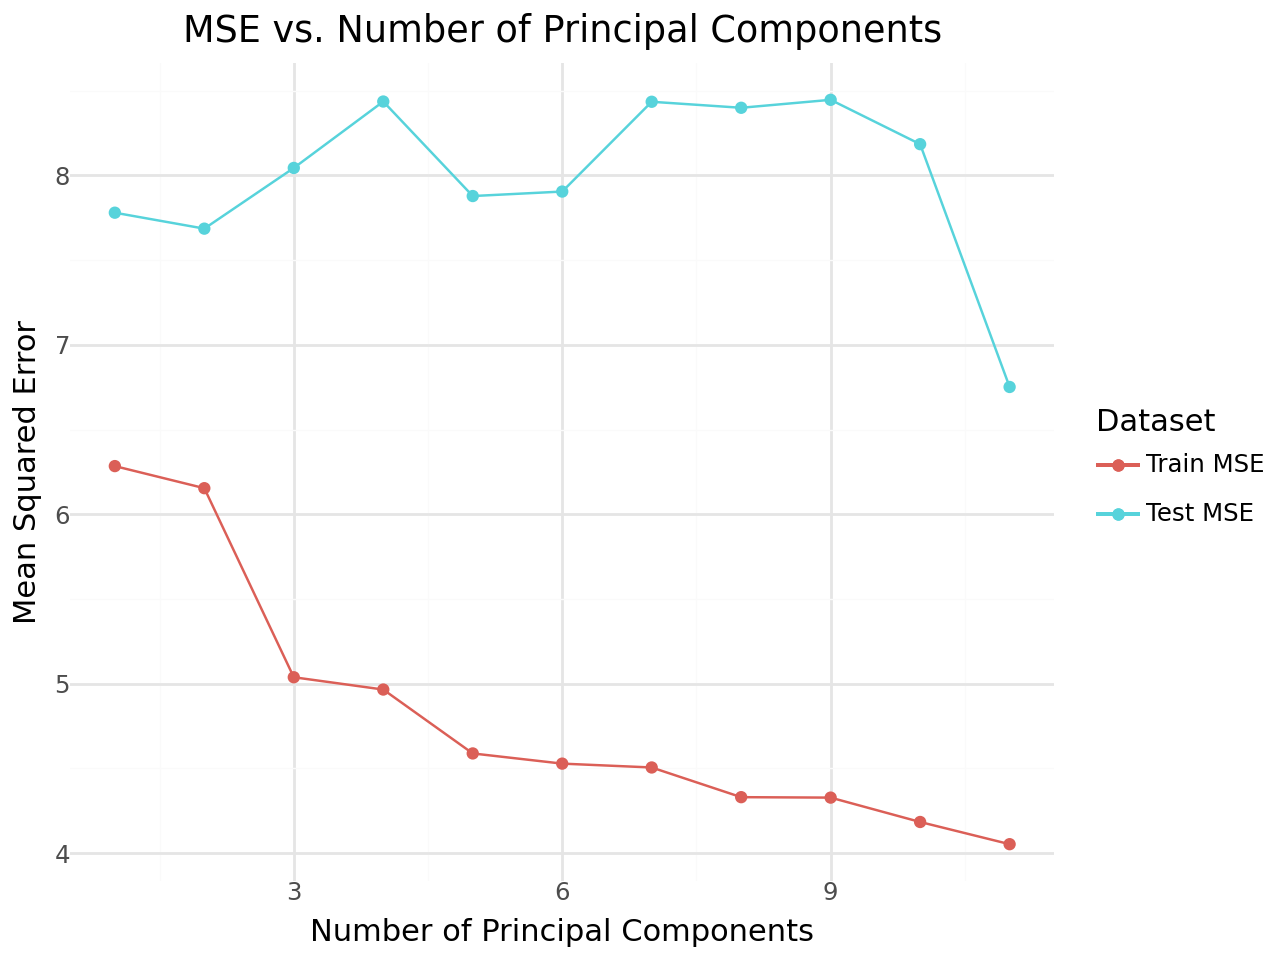

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, theme_minimal, labs
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Split data into features (X) and target (y)

predictors = ["Age", "Gender", "Current Weight (lbs)", "BMR (Calories)",
              "Daily Calories Consumed", "Daily Caloric Surplus/Deficit",
              "Weight Change (lbs)", "Duration (weeks)",
              "Physical Activity Level", "Sleep Quality", "Final Weight (lbs)"]

contin = ["Age", "Current Weight (lbs)", "BMR (Calories)", "Daily Calories Consumed",
          "Daily Caloric Surplus/Deficit", "Weight Change (lbs)",
          "Duration (weeks)", "Final Weight (lbs)"]
X = data[predictors]
y = data["Stress Level"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
z = make_column_transformer(
    (StandardScaler(), contin),
    (OneHotEncoder(), ["Gender", "Physical Activity Level", "Sleep Quality"]),
    remainder="passthrough"
)

# Store results
mse_results = []

# Determine the maximum number of components
max_components = X_train.shape[1]  # Total number of features in the dataset

# Fit PCA and compute MSE for each number of components
for num_pcs in range(1, max_components + 1):
    # PCA pipeline with a fixed number of components
    pca = PCA(n_components=num_pcs)
    pipe = Pipeline([
        ("z", z),
        ("pca", pca),
        ("model", LinearRegression())
    ])

    # Fit pipeline on training data
    pipe.fit(X_train, y_train)

    # Predict and compute MSE for train and test sets
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Store results
    mse_results.append({"num_pcs": num_pcs, "train_mse": train_mse, "test_mse": test_mse})

# Convert results to DataFrame
mse_df = pd.DataFrame(mse_results)

# Plot MSE as a function of the number of PCs
mse_plot = (
    ggplot(mse_df, aes(x="num_pcs")) +
    geom_line(aes(y="train_mse", color="'Train MSE'")) +
    geom_line(aes(y="test_mse", color="'Test MSE'")) +
    geom_point(aes(y="train_mse", color="'Train MSE'")) +
    geom_point(aes(y="test_mse", color="'Test MSE'")) +
    theme_minimal() +
    labs(
        title="MSE vs. Number of Principal Components",
        x="Number of Principal Components",
        y="Mean Squared Error",
        color="Dataset"
    )
)

mse_plot
